In [1]:
import pykat
from pykat import finesse
from pykat.commands import *
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.rc('font', size= 20)
plt.rc('axes', titlesize= 20)
from pylab import rcParams
rcParams['figure.figsize'] = 10, 15
pykat.init_pykat_plotting(dpi=50,fmts=['png'])

                                              ..-
    PyKat 1.1.331         _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,
   `^-....____:   +.      www.gwoptics.org/pykat



In [4]:
# Finesse Solution
base = finesse.kat()
base.verbose=False
base.parse(
"""
l laser 1 0 n0              # Laser 1W
s s0 1 n0 n1                # Distance from the laser to the first mirror M1
    
#Cavity:
m M1 0.9999999999999999 0.0000000000000001 0 n1 n2      # Cavity mirror M1: R = 0.999, T = 0.001
s s_cav 0.1 n2 n3           # Cavity Length: L =  0.1 m
m M2 1 0 0 n3 n4            # Cavity mirror M2: R = 1, T = 0
attr M2 Rc 0.5              # Radius of curvature of M2 = 0.5 m
cav cavity M1 n2 M2 n3
"""
)

base.maxtem = 1
base.trace = 2

kat = base.deepcopy()
kat.noxaxis = True
kat.parse(
"""
# Mirror Movement
#attr M2 xbeta 1u

# Detectors:    
ad det00 0 0 0 n2*
ad det10 1 0 0 n2*
bp beam x w n2*
bp beam_2 x w n3
ad det00_2 0 0 0 n3
ad det10_2 1 0 0 n3
    
# Mirror tilt and axes
xaxis M1 xbeta lin -1u 1u 1000    
yaxis re:im
""")

out = kat.run()
# print(out.stdout)
#out.info()

In [7]:
w1 = out['beam'].real # beam size
w2 = out['beam_2'].real
div_ang1 = 1064e-9/(w1*np.pi)
#div_ang2 = 1064e-9/(w2*np.pi)
a_00_1 = out['det00']
a_00_2 = out['det00_2']
a_10_1 = out['det10']
a_10_2 = out['det10_2']

intermodalphase1 = abs(np.angle(out['det10']) - np.angle(out['det00']))
intermodalphase2 = abs(np.angle(out['det10_2']) - np.angle(out['det00_2']))

theta_1 = 0                    # M1 tilt 
theta_2 = 1e-6                        # M2 tilt 

# Cavity parameters:
L = 0.1                        # Cavity Length
RcM2 = 0.5                     # Radius of curvature of M2 mirror = 0.5 m
g1 = 1                       # g1 = 1 - L/RcM1 = 1 since RcM1 = infinity
g2 = 1 - L/RcM2                # g2 for M2 mirror
#print('g1g2 =', g1*g2)         # Stability ch

#delx_1 = w1*a_10_1.real/np.abs(a_00_1)
#delx_2 = w2*a_10_2.real/np.abs(a_00_2)
delx_1 = w1*(np.abs(a_10_1)*np.cos(intermodalphase1))/np.abs(a_00_1)
delx_2 = w2*(np.abs(a_10_2)*np.cos(intermodalphase2))/np.abs(a_00_2)

#delalpha_1 = div_ang1*(a_10_1.imag/np.abs(a_00_1))
#delalpha_2 = div_ang2*(a_10_2.imag/np.abs(a_00_2))
             
delalpha_1 = div_ang1*((np.abs(a_10_1)*np.sin(intermodalphase1))/np.abs(a_00_1))
delalpha_2 = div_ang1*((np.abs(a_10_2)*np.sin(intermodalphase2))/np.abs(a_00_2))
del_thetaf = (delx_2 - delx_1)/L

delta_x1 = (g2/(1-g1*g2))*L*out.x + (1/(1- g1*g2))*L*0   # Displacement on M1
delta_x2 = (1/(1-g1*g2))*L*out.x + (g1/(1-g1*g2))*L*0     # Displacement on M2
delta_theta1 = (delta_x2 - delta_x1)/L
delta_theta2 = (delta_x2 - delta_x1)/L


#delta_theta2 = out.x*L*((1-g2)/(1-g1*g2))
#delta_theta1 = out.x*L*((1-g1)/(1-g1*g2))
#delta_x2 = out.x*L*((1/(1-g1*g2)))
#delta_x1 = out.x*L*((g2/(1-g1*g2)))

In [14]:
print(abs(a_10_1[100]), abs(a_10_2[100]))
print(abs(a_00_1[100]), abs(a_00_2[100]))

9.093178983624262e-06 9.09317898362426e-06
0.0066148723222750885 0.0066148723222750885


No handles with labels found to put in legend.


Text(0, 0.5, 'Error')

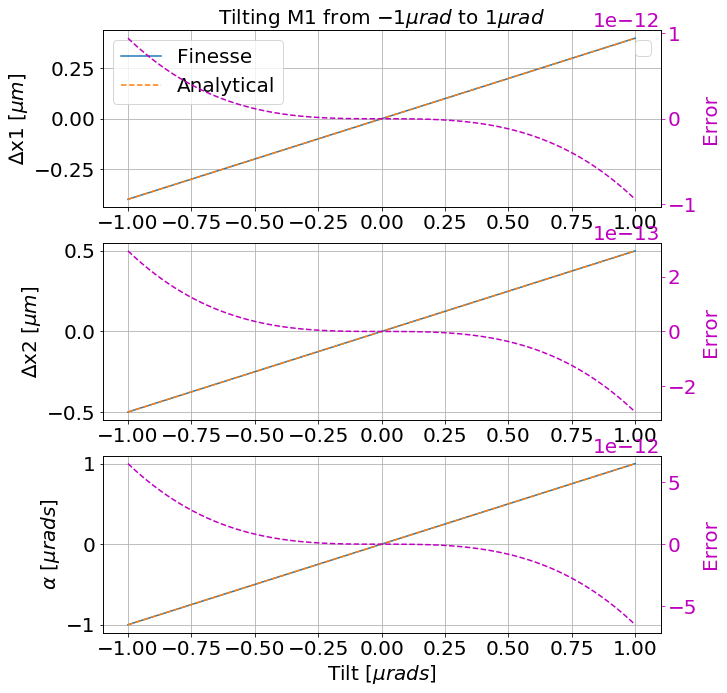

In [8]:
plt.subplot(4, 1, 1)
plt.title(r'Tilting M1 from $-1 \mu rad$ to $1 \mu rad$')
plt.grid(which='both')
plt.plot(1e6*out.x, 1e6*delx_1, label='Finesse')
plt.plot(1e6*out.x, 1e6*delta_x1, '--', label='Analytical')
plt.ylabel(r'∆x1 [$\mu m$]')
plt.legend()
plt.twinx()
plt.tick_params(axis='y', colors='m')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.plot(1e6*out.x, (delta_x1 - delx_1), 'm--')
plt.ylabel('Error', color='m')
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(1e6*out.x, 1e6*delx_2, label='Finesse')
plt.plot(1e6*out.x, 1e6*delta_x2, '--', label='Analytical')
plt.grid(which='both')
plt.ylabel(r'∆x2 [$\mu m$]')
plt.twinx()
plt.tick_params(axis='y', colors='m')
plt.plot(1e6*out.x, (delta_x2 - delx_2), 'm--')
plt.ylabel('Error', color='m')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
#plt.legend()

plt.subplot(4, 1, 3)
plt.plot(1e6*out.x, 1e6*del_thetaf, label='Finesse')
plt.plot(1e6*out.x, 1e6*delta_theta1, '--', label='Analytical')
plt.grid(which='both')
plt.xlabel(r'Tilt $[\mu rads]$')
plt.ylabel(r'$\alpha\,\,[\mu rads]$')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.twinx()
plt.tick_params(axis='y', colors='m')
#plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.plot(1e6*out.x, del_thetaf - delta_theta1, 'm--')
plt.ylabel('Error', color='m')
#plt.legend()

#plt.subplot(4, 1, 4)
#plt.plot(out.x, delalpha_2,'--', label='Finesse')
#plt.plot(out.x, delta_theta, label='Analytical' )
#plt.grid(which='both')
#plt.ylabel(r'$\alpha_{2}\,\,[\mu rads]$')
#plt.xlabel('Mirror Tilt')
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
#plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
#plt.twinx()
#plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
#plt.tick_params(axis='y', colors='m')
#plt.plot(out.x, delta_theta - delalpha_2, 'm--')
#plt.ylabel('Error', color='m')
#plt.legend()

#plt.savefig('M1_tilt.png')